In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

from src.SlovotvirModel import run_model_parallel

import numpy as np 

import pickle

In [5]:
# unpickle data/post_samples_final_0306.pkl
with open('data/post_samples_final_2012.pkl', 'rb') as f:
    post_samples = pickle.load(f)

In [9]:
# unpickle prior draws
with open('data/prior_draws.pkl', 'rb') as f:
    prior_draws = pickle.load(f)

In [11]:
true_likes = pickle.load(open("data/true_likes.pkl", "rb"))
true_lieks_lengths = pickle.load(open("data/true_len_likes.pkl", "rb"))

In [6]:
priors = [np.random.uniform(-5, 1, 50000), 
          np.random.uniform(-2, 2, 50000),
          np.random.lognormal(0, 0.5, 50000),]

param_names = ['Length bias (α)', 
               'Frequency bias (β)', 
               'Exploration bias (τ)']

post_hdi = az.hdi(post_samples, hdi_prob=0.95)

null = [0, 1, 1]

/var/folders/1c/pphtjl397rnbdcp94xmwzkqr0000gn/T/ipykernel_46406/2009658165.py:9: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  post_hdi = az.hdi(post_samples, hdi_prob=0.95)


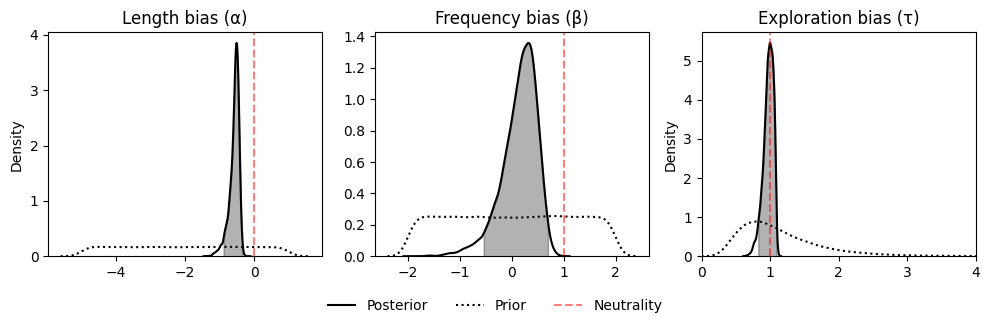

In [ ]:
# plot priors on three separate subplots

fig, ax = plt.subplots(1, 3, figsize=(10, 3))

for i in range(3):
    x_values, y_values = sns.kdeplot(post_samples[:, i], 
                                     ax=ax[i], 
                                     color='black',
                                     common_norm=True,
                                     label='Posterior').lines[0].get_data()
    y_values /= np.trapz(y_values, x_values)
    ax[i].fill_between(x_values, y_values, 
                       where=(x_values >= post_hdi[i][0]) & 
                        (x_values <= post_hdi[i][1]), color='black', alpha=0.3)
    
    sns.kdeplot(priors[i], ax=ax[i], 
                color='black', 
                linestyle='dotted',
                common_norm=True,
                label='Prior')
    ax[i].set_title(param_names[i])
    ax[i].axvline(null[i], 
                  color='red', 
                  linestyle='dashed',
                  alpha=0.5,
                  label='Neutrality')
    if i == 0:
        ax[i].set_ylabel('Density')
    elif i == 2:
        ax[i].set_xlim(0, 4)
    else:
        ax[i].set_ylabel('')
    # if i < 2: 
    #     ax[i].text(10, [0.46, 1][i], f'P(θ > {[0, 1][i]}) = {np.mean(post_samples[:, i] > null[i]):.2f}',
    #                  ha='right', va='top')    

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, 
           loc='lower center', ncol=3,
           frameon=False, bbox_to_anchor=(0.5, -0.1))

plt.tight_layout()
# save figure
plt.savefig('figures/posteriors_final.pdf',
            dpi=300, 
            bbox_inches='tight')
plt.show()

In [8]:
posterior_predictive = run_model_parallel(np.random.choice(post_samples[:, 0], 100), 
                                          np.random.choice(post_samples[:, 1], 100), 
                                          np.random.choice(post_samples[:, 2], 100), 100)

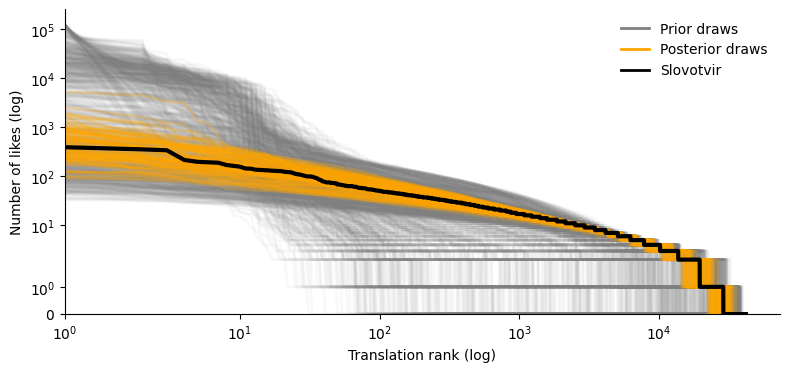

In [ ]:
plt.figure(figsize=(8, 4))  # Increased height to fit the plot

# First plot with log x-scale
ax1 = plt.subplot(1, 1, 1)

# Plot prior draws with label
for i, d in enumerate(prior_draws):
    label = 'Prior draws' if i == 0 else None
    ax1.plot(range(1, len(d) + 1), d, 
             color='grey', 
             alpha=0.05, 
             linewidth=2,
             label=label)

# Plot parameter estimates with label
for i, _ in enumerate(posterior_predictive):
    label = 'Posterior draws' if i == 0 else None
    ax1.plot(range(1, len(_[0]) + 1), _[0], 
             color='orange', 
             alpha=0.25, 
             linewidth=2,
             label=label)

ax1.plot(range(1, len(true_likes) + 1), 
         true_likes, 
         label='Slovotvir', 
         color='black', 
         linewidth=3, 
         alpha=1)

ax1.set_xscale('symlog', base=10)
ax1.set_yscale("symlog", base=10)
ax1.set_xlabel('Translation rank (log)')
ax1.set_ylabel('Number of likes (log)')
ax1.set_ylim(0, None)
ax1.set_xlim(1, None)

sns.despine()

# Adjust layout to make room for the legend at the bottom
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)

# Create a legend and place it at the bottom
handles, labels = ax1.get_legend_handles_labels()
legend = plt.legend(handles, labels, frameon=False, ncol=1)
for legend_line in legend.get_lines():
    legend_line.set_alpha(1.0)
    legend_line.set_linewidth(2)

plt.show()

In [ ]:
N = 100

# length_bias_ = run_model_parallel([-2] * N, 
#                                   np.random.choice(post_samples[:, 1], N), 
#                                   np.random.choice(post_samples[:, 2], N), 
#                                   N)
neutral_ = run_model_parallel([0] * N, 
                              np.random.choice(post_samples[:, 1], N), 
                              np.random.choice(post_samples[:, 2], N), 
                              N)

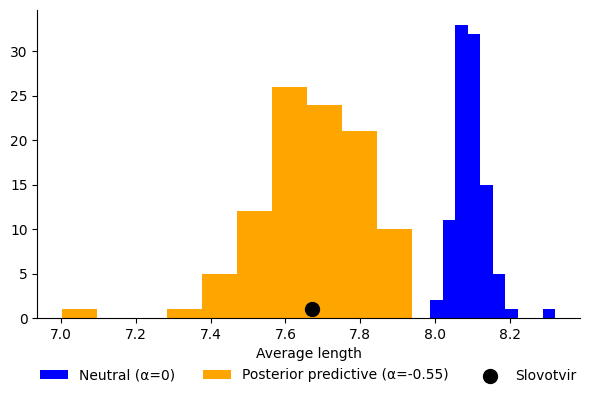

In [50]:
plt.figure(figsize=(7, 4))

# plt.hist([sum(y) / sum(x) for x, y in length_bias_], 
#          bins=10,
#          label='Negative length bias (α=-1)', 
#          color='blue', 
#          alpha=1, 
#          density=False,)
plt.hist([sum(y) / sum(x) for x, y in neutral_], 
         bins=10,
         label='Neutral (α=0)', 
         color='blue', 
         alpha=1, 
         density=False,)
plt.hist([sum(y) / sum(x) for x, y in posterior_predictive], 
         bins=10,
         label='Posterior predictive (α=-0.55)', 
         color='orange', 
         alpha=1, 
         density=False)
plt.scatter(np.mean([sum(y) / sum(x) for x, y in posterior_predictive]), 
            1, color='black', s=100, label='Slovotvir')

plt.xlabel('Average length')

plt.legend(frameon=False, loc='lower center', 
           ncol=3, 
           bbox_to_anchor=(0.5, -0.25),
           #text size
           fontsize=10)
sns.despine()
plt.show()